## Libraries

In [1]:
import numpy as np
import tensorflow as tf
import keras
from IPython.display import Image, display
from zipfile import ZipFile
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,BatchNormalization, Conv2D, MaxPooling2D, LSTM, GRU
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet50, densenet, efficientnet
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import albumentations as A
import pandas as pd
import cv2
import os
import tempfile
import collections

2023-05-19 19:02:24.168515: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-19 19:02:24.221762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 19:02:26.199029: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Connect to Data

In [2]:
train_path = "face_age_data/face_age_balanced_train"
augment_path = "face_age_data/augmented_data_train"
val_path = "face_age_data/face_age_balanced_val"
test_path = "face_age_data/face_age_balanced_test"

In [3]:
def load_data(path, img_size=(200, 200, 3)):
    X = []
    y = []
    for folder_name in os.listdir(path):
        folder_path = os.path.join(path, folder_name)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            img = cv2.imread(file_path)
            img.resize(img_size)
            img = img / 255
            X.append(img)
            y.append(int(folder_name[-3:]))
    
    return np.array(X), np.array(y)

In [4]:
train_data = load_data(train_path)
augment_data = load_data(augment_path)
val_data = load_data(val_path)
test_data = load_data(test_path)

In [5]:
X_train = np.concatenate((train_data[0], augment_data[0]))
y_train = np.concatenate((train_data[1], augment_data[1]))

## Transfer Learning

In [6]:
def set_gpus(*gpu_indices):
    # Get list of GPUs
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print("Num GPUs Available: ", len(gpus))

    if gpus:
        visible_gpus = [gpus[i] for i in gpu_indices]
        try:
            # Only use specified GPUs and ignore the others
            tf.config.experimental.set_visible_devices(visible_gpus, 'GPU')
            for gpu in visible_gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("Using GPUs: ", [gpu.name for gpu in visible_gpus])
        except RuntimeError as e:
            print(e)
    return visible_gpus

# Call the function with the indices of the GPUs you want to use
visible_gpus = set_gpus(0, 1, 2, 3, 4)  # Use the second, third, fourth, and fifth GPU

# Extract names of the GPUs being used
gpu_names = ['/device:GPU:' + gpu.name.split(':')[-1] for gpu in visible_gpus]
print(gpu_names)

strategy = tf.distribute.MirroredStrategy(devices=gpu_names)

Num GPUs Available:  5
Using GPUs:  ['/physical_device:GPU:0', '/physical_device:GPU:1', '/physical_device:GPU:2', '/physical_device:GPU:3', '/physical_device:GPU:4']
['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3', '/device:GPU:4']
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')


2023-05-19 19:07:30.085704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46671 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1a:00.0, compute capability: 8.6
2023-05-19 19:07:30.086575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46671 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:1b:00.0, compute capability: 8.6
2023-05-19 19:07:30.087266: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46671 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:88:00.0, compute capability: 8.6
2023-05-19 19:07:30.087996: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46671 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:89:00.0, 

### EfficientNetB7 (retrain 10 layers)

In [9]:
def create_model():
    tf_model = efficientnet.EfficientNetB7(weights="imagenet", include_top=False, input_shape=(200, 200, 3))
    
    for layer in tf_model.layers[:-10]:
        layer.trainable = False

    # Adding custom Layers 
    x = tf_model.output
    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1)(x)

    # creating the final model 
    model_final = Model(tf_model.input, predictions)
    
    model_final.compile(loss="mean_squared_error",
                    optimizer=tf.keras.optimizers.legacy.Adadelta(),
                    metrics=["mae"])
    
    return model_final

with strategy.scope():
    model_final = create_model()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

#### With Data Augmentation

In [10]:
history = model_final.fit(X_train,
                        y_train,
                        verbose=2,
                        epochs=10,
                        validation_data=(val_data[0], val_data[1]))

2023-05-19 01:12:42.510703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [45000]
	 [[{{node Placeholder/_11}}]]
2023-05-19 01:12:42.511296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [45000,200,200,3]
	 [[{{node Placeholder/_10}}]]


Epoch 1/10


2023-05-19 01:12:43.217178: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 01:12:43.217794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localho

2023-05-19 01:13:59.344554: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-19 01:14:11.605575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-19 01:14:13.091909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-19 01:14:14.654316: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-19 01:14:14.918273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-19 01:14:16.428085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-19 01:14:16.844520: I tensorflow/compiler/xla/st

1407/1407 - 485s - loss: 720.4423 - mae: 22.9879 - val_loss: 796.0818 - val_mae: 24.6591 - 485s/epoch - 344ms/step
Epoch 2/10


2023-05-19 01:26:48.285086: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 01:26:48.285635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


1407/1407 - 364s - loss: 693.8542 - mae: 22.7178 - val_loss: 733.9774 - val_mae: 23.7665 - 364s/epoch - 259ms/step
Epoch 3/10


2023-05-19 01:32:50.035505: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 01:32:50.035984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


1407/1407 - 362s - loss: 689.7502 - mae: 22.6441 - val_loss: 739.9112 - val_mae: 23.8547 - 362s/epoch - 257ms/step
Epoch 4/10


2023-05-19 01:38:47.626125: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 01:38:47.626630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


1407/1407 - 358s - loss: 690.0047 - mae: 22.6703 - val_loss: 747.1068 - val_mae: 23.9607 - 358s/epoch - 254ms/step
Epoch 5/10


2023-05-19 01:44:44.947174: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 01:44:44.947650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


1407/1407 - 357s - loss: 691.7568 - mae: 22.6905 - val_loss: 736.2466 - val_mae: 23.7992 - 357s/epoch - 254ms/step
Epoch 6/10


2023-05-19 01:50:37.008622: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 01:50:37.009129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


1407/1407 - 352s - loss: 688.2084 - mae: 22.6453 - val_loss: 793.7579 - val_mae: 24.6266 - 352s/epoch - 250ms/step
Epoch 7/10


2023-05-19 01:56:30.539706: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 01:56:30.540196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


1407/1407 - 354s - loss: 689.1562 - mae: 22.6515 - val_loss: 720.9384 - val_mae: 23.5678 - 354s/epoch - 252ms/step
Epoch 8/10


2023-05-19 02:02:23.291226: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 02:02:23.291685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


1407/1407 - 353s - loss: 690.0359 - mae: 22.6778 - val_loss: 722.8564 - val_mae: 23.5963 - 353s/epoch - 251ms/step
Epoch 9/10


2023-05-19 02:08:14.733904: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 02:08:14.734404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


1407/1407 - 352s - loss: 689.7454 - mae: 22.6753 - val_loss: 752.9791 - val_mae: 24.0445 - 352s/epoch - 250ms/step
Epoch 10/10


2023-05-19 02:14:09.995011: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 02:14:09.995497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


1407/1407 - 355s - loss: 689.3438 - mae: 22.6435 - val_loss: 745.8930 - val_mae: 23.9412 - 355s/epoch - 252ms/step


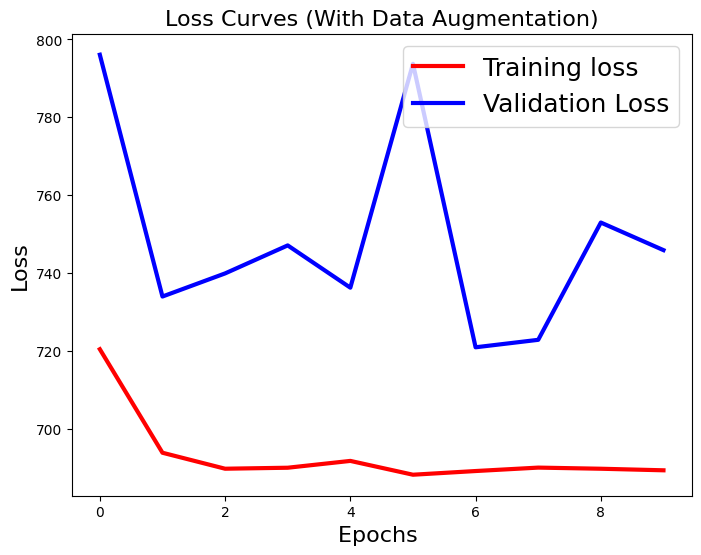

In [11]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves (With Data Augmentation)',fontsize=16)
plt.show()

#### Without Data Augmentation

In [12]:
history = model_final.fit(train_data[0],
                        train_data[1],
                        verbose=2,
                        epochs=10,
                        validation_data=(val_data[0], val_data[1]))

2023-05-19 02:23:28.694991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [5598]
	 [[{{node Placeholder/_11}}]]
2023-05-19 02:23:28.695421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [5598,200,200,3]
	 [[{{node Placeholder/_10}}]]


Epoch 1/10


2023-05-19 02:23:28.967282: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 02:23:28.967687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-19 02:24:14.687138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [1400]
	 [[{{node Placeholder/_11}}]]
2023-05-19 02:24:14.687455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0]

175/175 - 50s - loss: 586.9974 - mae: 20.5133 - val_loss: 579.8855 - val_mae: 20.3071 - 50s/epoch - 284ms/step
Epoch 2/10


2023-05-19 02:25:03.306044: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 02:25:03.306504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 49s - loss: 578.0447 - mae: 20.2612 - val_loss: 580.3904 - val_mae: 20.5005 - 49s/epoch - 277ms/step
Epoch 3/10


2023-05-19 02:25:51.222664: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 02:25:51.223087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 48s - loss: 577.0021 - mae: 20.2755 - val_loss: 579.7462 - val_mae: 20.3509 - 48s/epoch - 274ms/step
Epoch 4/10


2023-05-19 02:26:39.234697: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 02:26:39.235163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 48s - loss: 581.6473 - mae: 20.3600 - val_loss: 581.9820 - val_mae: 20.1673 - 48s/epoch - 273ms/step
Epoch 5/10


2023-05-19 02:27:27.535615: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 02:27:27.536101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 49s - loss: 580.7886 - mae: 20.3383 - val_loss: 580.6413 - val_mae: 20.2329 - 49s/epoch - 278ms/step
Epoch 6/10


2023-05-19 02:28:15.305073: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 02:28:15.305550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 47s - loss: 579.9174 - mae: 20.2820 - val_loss: 579.8488 - val_mae: 20.3119 - 47s/epoch - 270ms/step
Epoch 7/10


2023-05-19 02:29:02.892781: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 02:29:02.893203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 48s - loss: 576.3736 - mae: 20.2424 - val_loss: 579.7564 - val_mae: 20.4070 - 48s/epoch - 272ms/step
Epoch 8/10


2023-05-19 02:29:50.777349: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 02:29:50.777823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 48s - loss: 577.2546 - mae: 20.2225 - val_loss: 580.9659 - val_mae: 20.2077 - 48s/epoch - 274ms/step
Epoch 9/10


2023-05-19 02:30:38.744256: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 02:30:38.744748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 48s - loss: 579.9713 - mae: 20.2818 - val_loss: 581.1296 - val_mae: 20.1988 - 48s/epoch - 275ms/step
Epoch 10/10


2023-05-19 02:31:26.973775: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 02:31:26.974380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 48s - loss: 575.2066 - mae: 20.1960 - val_loss: 579.7238 - val_mae: 20.3964 - 48s/epoch - 274ms/step


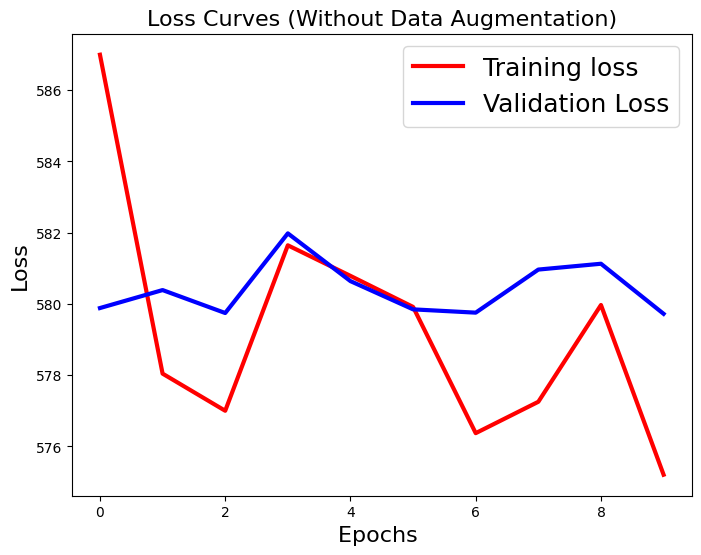

In [13]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves (Without Data Augmentation)',fontsize=16)
plt.show()

### EfficientNetB7 (retrain 50 layers)

In [7]:
def create_model():
    tf_model = efficientnet.EfficientNetB7(weights="imagenet", include_top=False, input_shape=(200, 200, 3))
    
    for layer in tf_model.layers[:-50]:
        layer.trainable = False

    # Adding custom Layers 
    x = tf_model.output
    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1)(x)

    # creating the final model 
    model_final = Model(tf_model.input, predictions)
    
    model_final.compile(loss="mean_squared_error",
                    optimizer=tf.keras.optimizers.legacy.Adadelta(),
                    metrics=["mae"])
    
    return model_final

with strategy.scope():
    model_final = create_model()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

#### With Data Augmentation

In [8]:
history = model_final.fit(X_train,
                        y_train,
                        verbose=2,
                        epochs=10,
                        validation_data=(val_data[0], val_data[1]))

2023-05-19 16:23:33.045018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [45000]
	 [[{{node Placeholder/_11}}]]
2023-05-19 16:23:33.045560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [45000]
	 [[{{node Placeholder/_11}}]]


Epoch 1/10
INFO:tensorflow:batch_all_reduce: 49 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 49 all-reduces with algorithm = nccl, num_packs = 1


2023-05-19 16:25:10.564821: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-19 16:25:26.633456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-19 16:25:29.308003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-19 16:25:29.453339: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-19 16:25:31.533862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-19 16:25:31.620334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-19 16:25:33.947878: I tensorflow/compiler/xla/st

1407/1407 - 470s - loss: 720.4947 - mae: 22.9959 - val_loss: 869.3796 - val_mae: 25.6252 - 470s/epoch - 334ms/step
Epoch 2/10
1407/1407 - 315s - loss: 688.4792 - mae: 22.6337 - val_loss: 857.0770 - val_mae: 25.4572 - 315s/epoch - 224ms/step
Epoch 3/10
1407/1407 - 312s - loss: 686.7189 - mae: 22.5996 - val_loss: 845.3694 - val_mae: 25.3003 - 312s/epoch - 222ms/step
Epoch 4/10
1407/1407 - 313s - loss: 684.5485 - mae: 22.5776 - val_loss: 776.2955 - val_mae: 24.3452 - 313s/epoch - 222ms/step
Epoch 5/10
1407/1407 - 311s - loss: 684.2861 - mae: 22.5781 - val_loss: 865.4832 - val_mae: 25.5511 - 311s/epoch - 221ms/step
Epoch 6/10
1407/1407 - 313s - loss: 683.3621 - mae: 22.5565 - val_loss: 801.7072 - val_mae: 24.6911 - 313s/epoch - 222ms/step
Epoch 7/10
1407/1407 - 313s - loss: 682.4781 - mae: 22.5230 - val_loss: 824.0093 - val_mae: 24.9917 - 313s/epoch - 223ms/step
Epoch 8/10
1407/1407 - 313s - loss: 681.1513 - mae: 22.5103 - val_loss: 830.9009 - val_mae: 25.0738 - 313s/epoch - 222ms/step
Epo

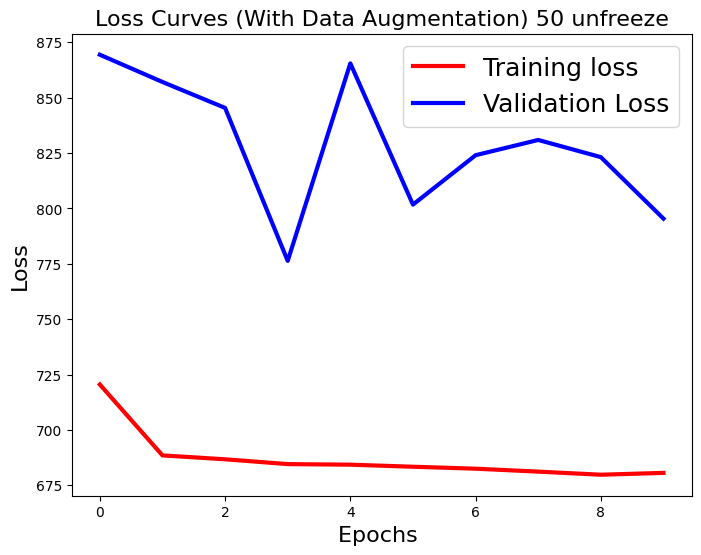

In [10]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves (With Data Augmentation) 50 unfreeze',fontsize=16)
plt.show()

In [8]:
history = model_final.fit(train_data[0],
                        train_data[1],
                        verbose=2,
                        epochs=10,
                        validation_data=(val_data[0], val_data[1]))

2023-05-19 03:29:07.116992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [5598,200,200,3]
	 [[{{node Placeholder/_10}}]]
2023-05-19 03:29:07.117359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [5598,200,200,3]
	 [[{{node Placeholder/_10}}]]


Epoch 1/10


2023-05-19 03:29:07.503829: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 03:29:07.504448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localho

2023-05-19 03:30:20.303632: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-19 03:30:32.591697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-19 03:30:35.097016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-19 03:30:35.376397: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-19 03:30:37.273128: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-19 03:30:37.575027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-19 03:30:39.563283: I tensorflow/compiler/xla/st

175/175 - 171s - loss: 668.8016 - mae: 21.0568 - val_loss: 605.3899 - val_mae: 19.9133 - 171s/epoch - 980ms/step
Epoch 2/10


2023-05-19 03:32:49.404388: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 03:32:49.404872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 54s - loss: 582.1394 - mae: 20.3175 - val_loss: 589.7270 - val_mae: 20.9308 - 54s/epoch - 309ms/step
Epoch 3/10


2023-05-19 03:33:43.612210: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 03:33:43.612705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 54s - loss: 583.8209 - mae: 20.3418 - val_loss: 587.2267 - val_mae: 20.8543 - 54s/epoch - 310ms/step
Epoch 4/10


2023-05-19 03:34:37.599024: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 03:34:37.599648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 54s - loss: 584.4432 - mae: 20.3413 - val_loss: 585.5396 - val_mae: 20.7914 - 54s/epoch - 309ms/step
Epoch 5/10


2023-05-19 03:35:31.896946: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 03:35:31.897388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 54s - loss: 582.1559 - mae: 20.3032 - val_loss: 598.1317 - val_mae: 21.1965 - 54s/epoch - 311ms/step
Epoch 6/10


2023-05-19 03:36:25.627489: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 03:36:25.627960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 54s - loss: 580.1149 - mae: 20.2933 - val_loss: 588.2398 - val_mae: 20.8897 - 54s/epoch - 306ms/step
Epoch 7/10


2023-05-19 03:37:19.481099: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 03:37:19.481615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 54s - loss: 580.0106 - mae: 20.3032 - val_loss: 582.5715 - val_mae: 20.6492 - 54s/epoch - 307ms/step
Epoch 8/10


2023-05-19 03:38:13.175438: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 03:38:13.175969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 54s - loss: 580.2394 - mae: 20.2909 - val_loss: 580.5126 - val_mae: 20.5367 - 54s/epoch - 308ms/step
Epoch 9/10


2023-05-19 03:39:05.789921: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 03:39:05.790271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 52s - loss: 575.3243 - mae: 20.1968 - val_loss: 581.4733 - val_mae: 20.6095 - 52s/epoch - 299ms/step
Epoch 10/10


2023-05-19 03:39:58.354367: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 03:39:58.354789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 53s - loss: 579.1455 - mae: 20.2806 - val_loss: 581.6973 - val_mae: 20.6239 - 53s/epoch - 301ms/step


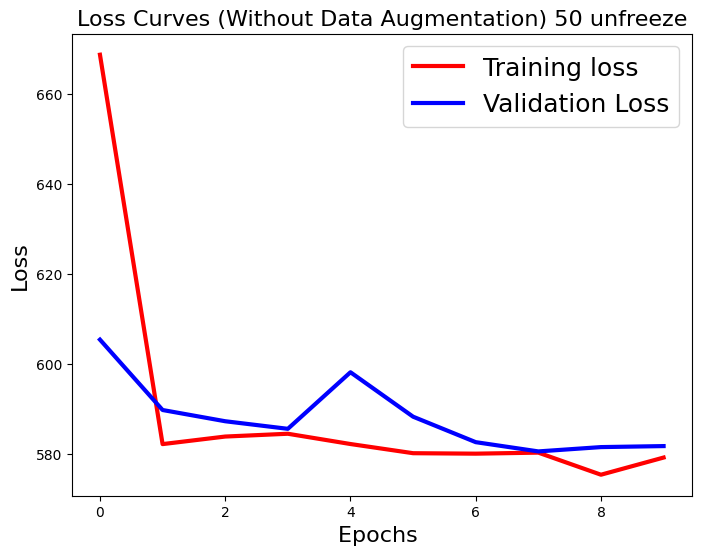

In [9]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves (Without Data Augmentation) 50 unfreeze',fontsize=16)
plt.show()

### EfficientNetB7 (retrain 10 layers with 1024 nodes)

In [7]:
def create_model():
    tf_model = efficientnet.EfficientNetB7(weights="imagenet", include_top=False, input_shape=(200, 200, 3))
    
    for layer in tf_model.layers[:-10]:
        layer.trainable = False

    # Adding custom Layers 
    x = tf_model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1)(x)

    # creating the final model 
    model_final = Model(tf_model.input, predictions)
    
    model_final.compile(loss="mean_squared_error",
                    optimizer=tf.keras.optimizers.legacy.Adadelta(),
                    metrics=["mae"])
    
    return model_final

with strategy.scope():
    model_final = create_model()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [8]:
history = model_final.fit(X_train,
                        y_train,
                        verbose=2,
                        epochs=10,
                        validation_data=(val_data[0], val_data[1]))

2023-05-19 19:09:11.906361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [45000]
	 [[{{node Placeholder/_11}}]]
2023-05-19 19:09:11.906782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [45000,200,200,3]
	 [[{{node Placeholder/_10}}]]


Epoch 1/10
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1


2023-05-19 19:10:41.641767: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-19 19:10:54.808851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-19 19:10:57.158638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-19 19:10:57.610739: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-19 19:10:59.373731: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-19 19:10:59.453788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-19 19:11:01.807368: I tensorflow/compiler/xla/st

1407/1407 - 497s - loss: 713.3835 - mae: 22.9316 - val_loss: 727.2623 - val_mae: 23.6647 - 497s/epoch - 353ms/step
Epoch 2/10
1407/1407 - 350s - loss: 685.8325 - mae: 22.6187 - val_loss: 813.7396 - val_mae: 24.9048 - 350s/epoch - 249ms/step
Epoch 3/10
1407/1407 - 350s - loss: 683.7383 - mae: 22.5883 - val_loss: 724.2637 - val_mae: 23.6195 - 350s/epoch - 249ms/step
Epoch 4/10
1407/1407 - 349s - loss: 684.9501 - mae: 22.6172 - val_loss: 739.4568 - val_mae: 23.8486 - 349s/epoch - 248ms/step
Epoch 5/10
1407/1407 - 345s - loss: 683.5156 - mae: 22.5954 - val_loss: 744.1599 - val_mae: 23.9179 - 345s/epoch - 245ms/step
Epoch 6/10
1407/1407 - 349s - loss: 684.9197 - mae: 22.6242 - val_loss: 748.2836 - val_mae: 23.9774 - 349s/epoch - 248ms/step
Epoch 7/10
1407/1407 - 350s - loss: 683.8850 - mae: 22.5866 - val_loss: 799.8973 - val_mae: 24.7122 - 350s/epoch - 249ms/step
Epoch 8/10
1407/1407 - 347s - loss: 682.7048 - mae: 22.5913 - val_loss: 726.5367 - val_mae: 23.6519 - 347s/epoch - 247ms/step
Epo

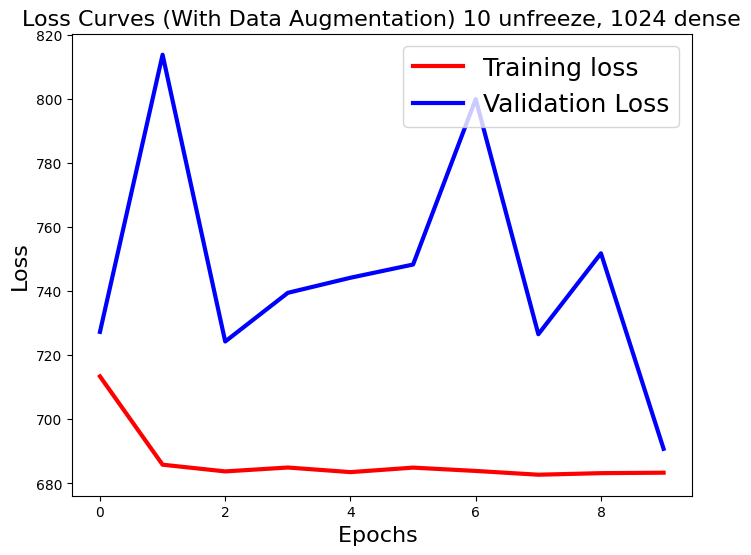

In [9]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves (With Data Augmentation) 10 unfreeze, 1024 dense',fontsize=16)
plt.show()

In [8]:
history = model_final.fit(train_data[0],
                        train_data[1],
                        verbose=2,
                        epochs=10,
                        validation_data=(val_data[0], val_data[1]))

2023-05-19 03:53:49.773853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [5598]
	 [[{{node Placeholder/_11}}]]
2023-05-19 03:53:49.774160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [5598]
	 [[{{node Placeholder/_11}}]]


Epoch 1/10


2023-05-19 03:53:50.093869: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 03:53:50.094212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/de

2023-05-19 03:54:39.229600: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-19 03:54:44.173035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-19 03:54:44.522479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-19 03:54:44.769689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-19 03:54:45.087543: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-19 03:55:48.391514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value 

175/175 - 140s - loss: 656.3663 - mae: 20.9675 - val_loss: 582.3173 - val_mae: 20.6120 - 140s/epoch - 797ms/step
Epoch 2/10


2023-05-19 03:57:11.157812: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 03:57:11.158168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 67s - loss: 585.4350 - mae: 20.3536 - val_loss: 582.1514 - val_mae: 20.2017 - 67s/epoch - 382ms/step
Epoch 3/10


2023-05-19 03:58:17.965517: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 03:58:17.965859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 67s - loss: 579.5665 - mae: 20.2300 - val_loss: 580.7805 - val_mae: 20.4566 - 67s/epoch - 381ms/step
Epoch 4/10


2023-05-19 03:59:24.821630: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 03:59:24.822083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 67s - loss: 581.2058 - mae: 20.3364 - val_loss: 580.5247 - val_mae: 20.3183 - 67s/epoch - 382ms/step
Epoch 5/10


2023-05-19 04:00:31.548780: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 04:00:31.549102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 67s - loss: 578.4404 - mae: 20.2557 - val_loss: 580.6461 - val_mae: 20.3128 - 67s/epoch - 382ms/step
Epoch 6/10


2023-05-19 04:01:38.368419: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 04:01:38.368737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 67s - loss: 579.5606 - mae: 20.2874 - val_loss: 581.0986 - val_mae: 20.2542 - 67s/epoch - 382ms/step
Epoch 7/10


2023-05-19 04:02:45.081941: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 04:02:45.082254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 67s - loss: 581.4678 - mae: 20.3075 - val_loss: 580.9075 - val_mae: 20.2707 - 67s/epoch - 381ms/step
Epoch 8/10


2023-05-19 04:03:51.943074: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 04:03:51.943406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 67s - loss: 576.7881 - mae: 20.2675 - val_loss: 581.5997 - val_mae: 20.5546 - 67s/epoch - 382ms/step
Epoch 9/10


2023-05-19 04:04:58.671693: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 04:04:58.672006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 67s - loss: 577.9219 - mae: 20.2739 - val_loss: 580.6583 - val_mae: 20.3037 - 67s/epoch - 381ms/step
Epoch 10/10


2023-05-19 04:06:05.378872: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-19 04:06:05.379176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


175/175 - 67s - loss: 579.7103 - mae: 20.2849 - val_loss: 580.7292 - val_mae: 20.2924 - 67s/epoch - 380ms/step


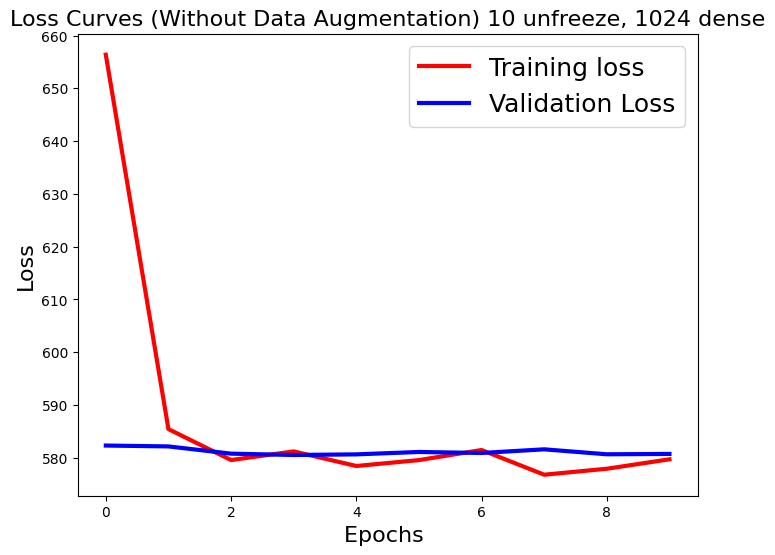

In [9]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves (Without Data Augmentation) 10 unfreeze, 1024 dense',fontsize=16)
plt.show()